Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
"

"\n// Inferring a Rate\ndata {\n  int N;\n  int<lower=0> k[N];\n  int<lower=1> n[N];\n}\nparameters {\n  real<lower=0,upper=1> theta;\n  real<lower=0,upper=1> thetaprior;\n}\nmodel {\n  // Prior Distribution for Rate Theta\n  theta ~ beta(1, 1);\n  thetaprior ~ beta(1, 1);\n\n  // Observed Counts\n  k ~ binomial(n, theta);\n}\n"

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchain)
# Use 16 observations
N2 = 4^2
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2))
k2 = rand(d, N2)

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/02


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/binomial.stan will be updated.



16-element Array{Int64,1}:
 7
 5
 5
 7
 5
 5
 6
 7
 6
 7
 6
 5
 5
 7
 6
 7

Input data for cmdstan

In [5]:
binomialdata = [
  Dict("N" => length(n2), "n" => n2, "k" => k2)
]

1-element Array{Dict{String,Any},1}:
 Dict("N"=>16,"k"=>[7, 5, 5, 7, 5, 5, 6, 7, 6, 7, 6, 5, 5, 7, 6, 7],"n"=>[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

Sample using cmdstan

In [6]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# Describe the draws
describe(chn)



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/binomial.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/binomial.hpp
Model name=binomial_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/binomial.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/binomial.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/dev/StatisticalRethinking/chapters/02/tmp/bino

Plot the 4 chains

res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.6636174630000002, σ=0.03923927280422808)
res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.6654422779999992, σ=0.03797138504691021)
res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.6668437170000001, σ=0.041019820319705344)
res = fit_mle(Normal, vals) = Normal{Float64}(μ=0.6640943050000003, σ=0.03687697756221318)


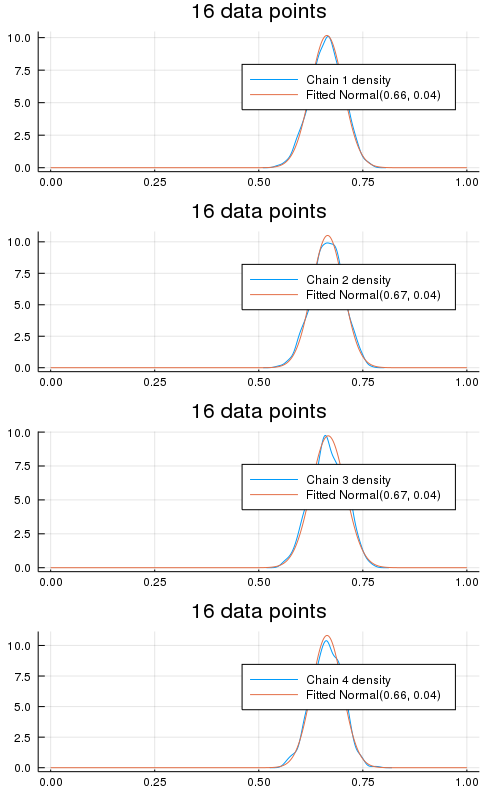

In [7]:
if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    @show res = fit_mle(Normal, vals)
    μ = round(res.μ, digits=2)
    σ = round(res.σ, digits=2)
    p[i] = density(vals, lab="Chain $i density", title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(res.μ, res.σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

##-

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*